# Biodiversity data - Codecademy Portfolio Project

We will be exploring two CSV files:

* species_info.csv - contains data about different species and their conservation status
* observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

species_info.csv:

* category - class of animal
* scientific_name - the scientific name of each species
* common_name - the common names of each species
* conservation_status - each species’ current conservation status

observations.csv:

* scientific_name - the scientific name of each species
* park_name - Park where species were found
* observations - the number of times each species was observed at park

### Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display
# from tabulate import tabulate

## Data file species_info.csv

### Loading

In [2]:
species_info = pd.read_csv('species_info.csv')
# print(tabulate(species_info.head(), headers='keys', tablefmt='pretty'))
display(species_info.head())

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


### Columns data types and counts

In [29]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [46]:
maxRows = species_info['category'].count()
print('Missing Data:')
percent = (1 - species_info.count() / maxRows) * 100
print(percent.apply(lambda x: '{:.2f}%'.format(x)))

Missing Data:
category                0.00%
scientific_name         0.00%
common_names            0.00%
conservation_status    96.72%
dtype: object


### Observations

* The conservation_status column seem to contains mosty NaN values. Only about 3% non-missing values.
* The other three columns do not seem to miss data.

### Checking the categories of the columns

In [10]:
print(species_info.category.value_counts())
print()
print(species_info.scientific_name.value_counts())
print()
print(species_info.common_names.value_counts())
print()
print(species_info.conservation_status.value_counts())

category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64

scientific_name
Procyon lotor             3
Myotis lucifugus          3
Canis lupus               3
Castor canadensis         3
Hypochaeris radicata      3
                         ..
Solanum parishii          1
Solanum xanti             1
Parthenocissus vitacea    1
Vitis californica         1
Saxifraga oregana         1
Name: count, Length: 5541, dtype: int64

common_names
Brachythecium Moss                                                            7
Dicranum Moss                                                                 7
Bryum Moss                                                                    6
Panic Grass                                                                   6
Sphagnum                                                                      6
    

### Observations

* The columns **category** and **conservation_status** contains substantial categories
* About 80% of the "animals" in the dataset are **plants**.
* The columns **scientific_name** and **common_names** contain strings
* The columns **scientific_name** and **common_names** are supposedly unique values. Yet we can see that both contains duplicates. We need to investigate and eliminate this.
* The columns **scientific_name**
* In the column **conservation_status**
  * Only about 3% of the data are not missing
  * The values 'Species of Concern', 'Endangered' and 'Threatened' seem to mean the same.  
The fourth value 'In Recovery' seems also to mean 'of concern' but perhaps more specific.
* Accordingly, l will add a new column **is_endangered** which is true iff conservation_status is not null

 ### Adding a column: is_endangered

In [11]:
species_info['is_endangered'] = ~species_info['conservation_status'].isnull()
print(species_info['is_endangered'].value_counts())


is_endangered
False    5633
True      191
Name: count, dtype: int64


### Checking scientific_name duplicates

In [26]:
has_duplicate_scientific_names = species_info.duplicated(subset=['scientific_name'])
print('Count duplicated scientific names:')
print(has_duplicate_scientific_names.sum())

duplicate_scientific_names = species_info.scientific_name[species_info.scientific_name.duplicated()]

# Display the first 5 duplicate scientific names
print("\nDisplay some duplicate scientific names")
for name in duplicate_scientific_names[:5]:
    display(species_info[species_info['scientific_name'] == name])

Count duplicated scientific names:
283

Display some duplicate scientific names


,category,scientific_name,common_names,conservation_status,is_endangered
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN,False
3017,Mammal,Cervus elaphus,Rocky Mountain Elk,NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN,False
3019,Mammal,Odocoileus virginianus,"White-Tailed Deer, White-Tailed Deer",NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
8,Mammal,Canis lupus,Gray Wolf,Endangered,True
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery,True
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,True


,category,scientific_name,common_names,conservation_status,is_endangered
16,Mammal,Puma concolor,Panther (Mountain Lion),NaN,False
3022,Mammal,Puma concolor,"Cougar, Mountain Lion, Puma",NaN,False
4451,Mammal,Puma concolor,Mountain Lion,NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
20,Mammal,Lutra canadensis,Northern River Otter,NaN,False
3025,Mammal,Lutra canadensis,River Otter,NaN,False


### Observations

* We have rows with duplicate scientific_name that we need to eliminate
* But not by simple deletion. We need to accumulate all the common_names that have been assigned to a scientific_name in the various duplicates

### Distribution by Species Category

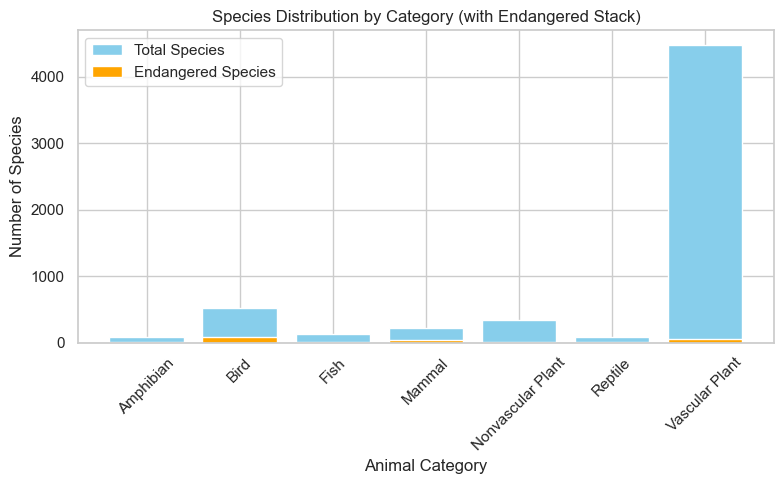

In [32]:
# Count the total number of species and endangered species per category
category_counts = species_info.groupby('category').agg(
    total_species=('is_endangered', 'size'),
    endangered_species=('is_endangered', 'sum')
).reset_index()

# Plotting the stacked bar chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot total species as base bars
plt.bar(
    category_counts['category'], 
    category_counts['total_species'], 
    color='skyblue', 
    label='Total Species'
)

# Add endangered species as stacked bars
plt.bar(
    category_counts['category'], 
    category_counts['endangered_species'], 
    color='orange', 
    label='Endangered Species'
)

# Add labels and titles
plt.title('Species Distribution by Category (with Endangered Stack)')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


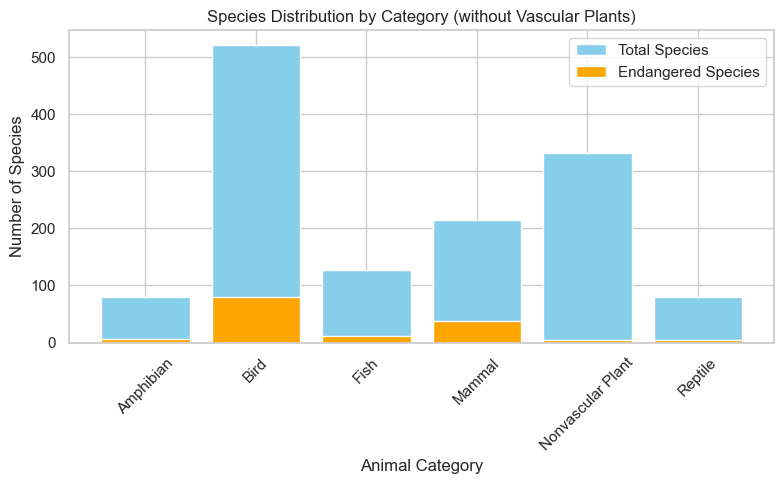

In [35]:
# Display only categories with less than 1000 species
category_counts = category_counts[category_counts['total_species'] < 1000]

# Plotting the bar chart with updated practices
plt.figure(figsize=(8, 5))

# Plot total species as base bars
plt.bar(
    category_counts['category'], 
    category_counts['total_species'], 
    color='skyblue', 
    label='Total Species'
)

# Add endangered species as stacked bars
plt.bar(
    category_counts['category'], 
    category_counts['endangered_species'], 
    color='orange', 
    label='Endangered Species'
)

# Add labels and titles
plt.title('Species Distribution by Category (without Vascular Plants)')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Observations

* The Vascular Plant category is by far the most populated category in the dataset. In has about 10 times more species than the next category in size, which is Birds.
* Categories which have significant percentages of endangered species are: Bird, Mammal, Fish.

### Missing conservation_status data per species category

Let's see if there is a visible relationship between species category and missing data on conservation status.

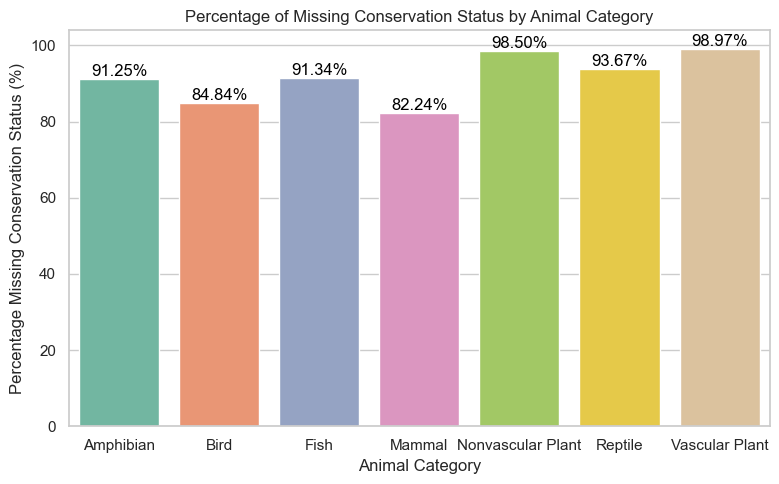

In [ ]:
# Group the DataFrame and compute the percentages
agg_df = species_info.groupby('category').agg(
    total_instances=('conservation_status', 'size'),
    missing_count=('conservation_status', lambda x: x.isnull().sum())
).reset_index()

# Calculate percentage and format it for printing
agg_df['missing_percentage'] = (agg_df['missing_count'] / agg_df['total_instances']) * 100
agg_df['formatted_percentage'] = agg_df['missing_percentage'].map("{:.2f}%".format)

# print("Percentage of missing 'conservation_status' values by animal category:")
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn to visualize percentages
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='missing_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Missing Conservation Status by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage Missing Conservation Status (%)')

# Add data labels showing the percentages above each bar
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['missing_percentage'],
        f"{row['missing_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()


### Observations

The missing values in conservation status seem nearly evenly distributed amoung the species categories.  
There is no visible correlations between missing values and species category.

### Endangered species per species category

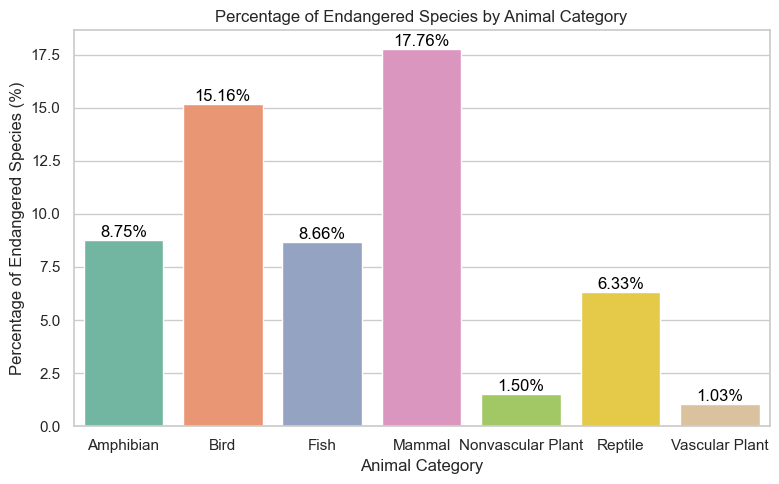

In [16]:
# Group the DataFrame and calculate the percentage of endangered species
agg_df = species_info.groupby('category').agg(
    total_instances=('is_endangered', 'size'),
    endangered_count=('is_endangered', 'sum')
).reset_index()

# Calculate percentage of endangered species
agg_df['endangered_percentage'] = (agg_df['endangered_count'] / agg_df['total_instances']) * 100

# print("Percentage of endangered species by animal category:")
# agg_df['formatted_percentage'] = agg_df['endangered_percentage'].map("{:.2f}%".format)
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='endangered_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Endangered Species by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage of Endangered Species (%)')

# Add percentage labels above bars
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['endangered_percentage'],
        f"{row['endangered_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

### Observations

We can see that most species that are indicated as endangered in the dataset are either mammals or birds.  
Relatively few of the plants species are considered endangered.

## Data file observations.csv

### Loading

In [4]:
observations = pd.read_csv('observations.csv')
display(observations.head())

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Columns data types and counts

In [5]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


### Observations

There are no missing data in the observations dataset.

### Park names

In [6]:
observations.park_name.value_counts()

park_name
Great Smoky Mountains National Park    5824
Yosemite National Park                 5824
Bryce National Park                    5824
Yellowstone National Park              5824
Name: count, dtype: int64

### Observations

The observations dataset contain data on observations of animals and plants in four parks.  
Judging by the number of rows, it seems that for each of the four parks we have a row for every species in the species_info dataset.

## The two datasets together

### Merging the two datasets

In [8]:
# Merge the dataframes on 'scientific_name'
merged_df = pd.merge(observations, species_info, on='scientific_name')

print("Merged DataFrame:")
display(merged_df.head())
print(merged_df.info())
print()
print(merged_df.park_name.value_counts())

# Aggregate data: calculate total and endangered observations for each park and category
agg_df = merged_df.groupby(['park_name', 'category']).agg(
    total_observations=('observations', 'sum'),
    endangered_observations=('is_endangered', lambda x: (x * merged_df.loc[x.index, 'observations']).sum())
).reset_index()

print("Aggregated observations data:")
display(agg_df)

Merged DataFrame:


,scientific_name,park_name,observations,category,common_names,conservation_status,is_endangered
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",NaN,False
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,NaN,False
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,NaN,False
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,NaN,False
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,NaN,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      25632 non-null  object
 1   park_name            25632 non-null  object
 2   observations         25632 non-null  int64 
 3   category             25632 non-null  object
 4   common_names         25632 non-null  object
 5   conservation_status  880 non-null    object
 6   is_endangered        25632 non-null  bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 1.2+ MB
None

park_name
Great Smoky Mountains National Park    6408
Yosemite National Park                 6408
Bryce National Park                    6408
Yellowstone National Park              6408
Name: count, dtype: int64
Aggregated observations data:


,park_name,category,total_observations,endangered_observations
0,Bryce National Park,Amphibian,7542,498
1,Bryce National Park,Bird,58590,7608
2,Bryce National Park,Fish,12823,731
3,Bryce National Park,Mammal,28830,4701
4,Bryce National Park,Nonvascular Plant,32992,486
5,Bryce National Park,Reptile,8141,387
6,Bryce National Park,Vascular Plant,484373,4198
7,Great Smoky Mountains National Park,Amphibian,5876,333
8,Great Smoky Mountains National Park,Bird,42869,5297
9,Great Smoky Mountains National Park,Fish,9482,547


### Debug: Check marging and aggregation

In [ ]:
# Check if duplicate scientific names exist after merging
has_duplicate_scientific_names = merged_df['scientific_name'].value_counts()
print("\nDuplicate Counts for scientific_name:")
print(has_duplicate_scientific_names[has_duplicate_scientific_names > 1])


Duplicate Counts for scientific_name:
scientific_name
Puma concolor                             36
Hypochaeris radicata                      36
Canis lupus                               36
Castor canadensis                         36
Procyon lotor                             36
                                          ..
Listera borealis                           4
Trifolium gracilentum var. gracilentum     4
Ranunculus hebecarpus                      4
Gulo gulo                                  4
Cornus sericea ssp. sericea                4
Name: count, Length: 5541, dtype: int64


### Observations by Category for each Park

Since there are much more observations in the "Vascular Plant" category, I will visuaize that category in a separate graph.

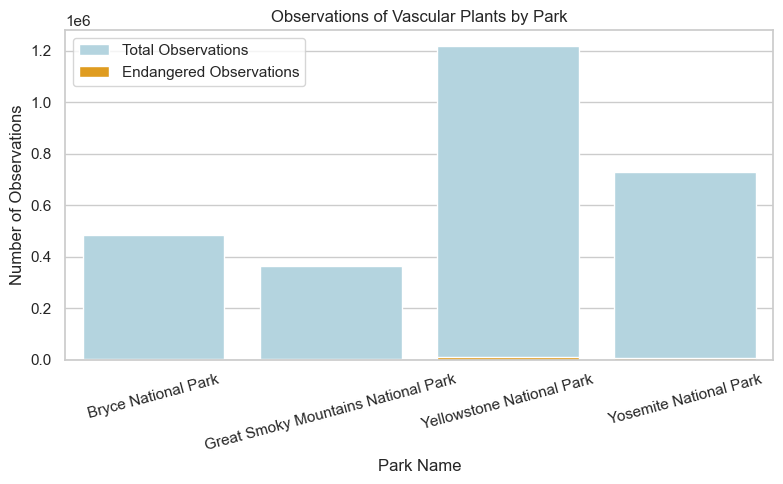

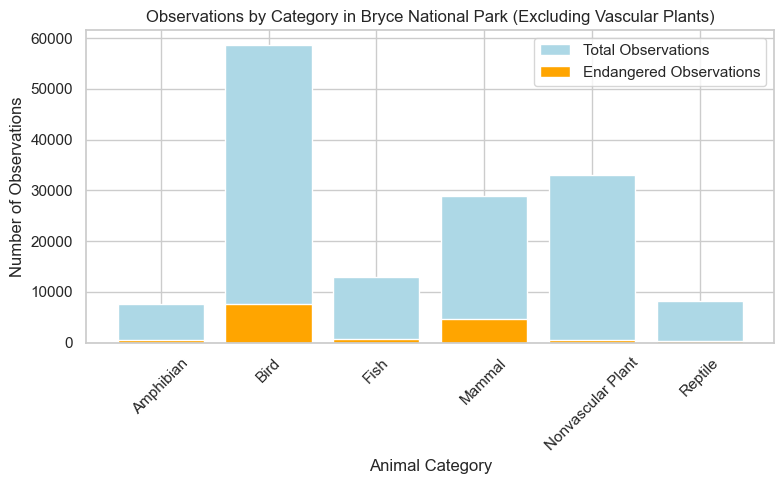

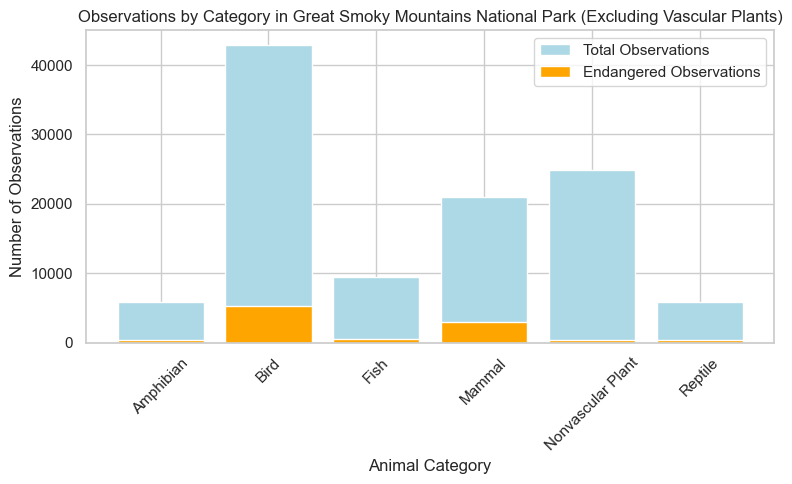

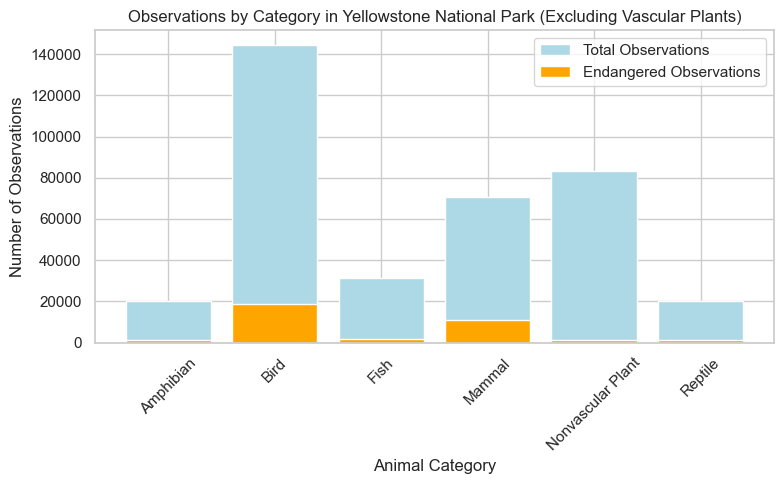

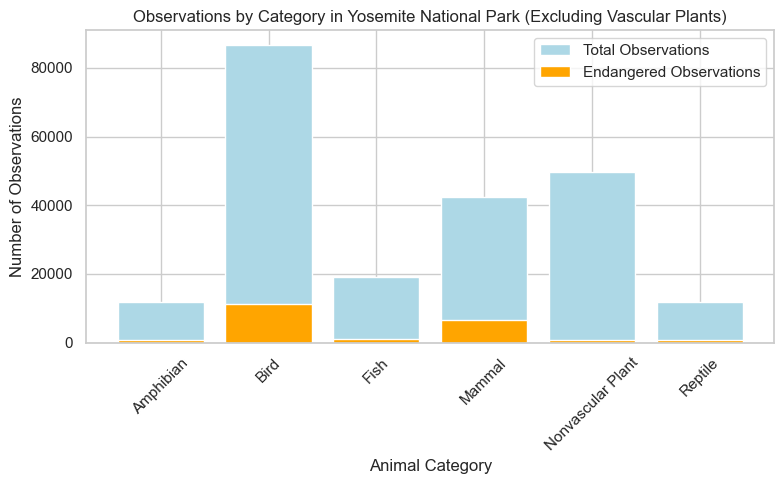

In [27]:
# Assuming 'agg_df' contains the aggregated data from the previous steps
# Splitting the data into "Vascular Plant" and other categories
vascular_plant_data = agg_df[agg_df['category'] == 'Vascular Plant']
other_categories_data = agg_df[agg_df['category'] != 'Vascular Plant']

# Plot for "Vascular Plant" category by park
plt.figure(figsize=(8, 5))
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='total_observations',
    color='lightblue',
    label='Total Observations'
)
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='endangered_observations',
    color='orange',
    label='Endangered Observations'
)
plt.title('Observations of Vascular Plants by Park')
plt.xlabel('Park Name')
plt.ylabel('Number of Observations')
plt.xticks(rotation=15)  # Rotate labels for clarity
plt.legend()
plt.tight_layout()
plt.show()

# Plot for each park (other categories)
parks = other_categories_data['park_name'].unique()

for park in parks:
    park_data = other_categories_data[other_categories_data['park_name'] == park]
    
    plt.figure(figsize=(8, 5))
    plt.bar(
        park_data['category'],
        park_data['total_observations'],
        label='Total Observations',
        color='lightblue'
    )
    plt.bar(
        park_data['category'],
        park_data['endangered_observations'],
        label='Endangered Observations',
        color='orange'
    )
    plt.title(f'Observations by Category in {park} (Excluding Vascular Plants)')
    plt.xlabel('Animal Category')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45)  # Rotate labels for clarity
    plt.legend()
    plt.tight_layout()
    plt.show()


### Observations

* The graphs for the four parks look suspiciously similar. The absolute amount are different, but the distributions look very similar.
* This can be the result of a bug in the code, but it can also indicate the the data is repeated and duplicated. 
* I will check the last hypothesis.

## Investigating a Strange Phenomenon in the Graphs

### Checking whether the data is duplicated

The suspicion to be checked is that the data has been duplicated from park to park and only multiplied by a different contant for every park 😮

In [6]:
# import pandas as pd

# # Example observations DataFrame (from before)
# observations = pd.DataFrame({
#     'scientific_name': ['Panthera leo', 'Corvus corax', 'Crocodylus niloticus', 'Elephas maximus', 'Struthio camelus', 'Chelonia mydas', 'Canis lupus'],
#     'park_name': ['Park A', 'Park B', 'Park A', 'Park C', 'Park B', 'Park D', 'Park C'],
#     'observations': [150, 300, 50, 400, 200, 100, 500]
# })

# Pivot the DataFrame to make parks columns and categories rows
pivoted_data = observations.pivot_table(
    index='scientific_name',
    columns='park_name',
    values='observations',
    aggfunc='sum'
).fillna(0)

# Normalize the data by park (column-wise normalization)
normalized_data = pivoted_data.div(pivoted_data.sum(axis=0), axis=1)
print("Normalized Observations by Park:")
display(normalized_data)

# Check correlations between parks
correlations = normalized_data.corr()
print("\nCorrelation Coefficients Between Parks:")
display(correlations)

# Check multiplicative ratios between parks
ratios = pivoted_data.div(pivoted_data.iloc[:, 0], axis=0)  # Divide by observations in the first park
print("\nMultiplicative Ratios (using the first park as a reference):")
display(ratios)


Normalized Observations by Park:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
scientific_name,,,,
Abies bifolia,0.000189,0.000167,0.000149,0.000158
Abies concolor,0.000144,0.000234,0.000167,0.000237
Abies fraseri,0.000189,0.000188,0.000151,0.000127
Abietinella abietina,0.000175,0.000151,0.000168,0.000212
Abronia ammophila,0.000160,0.000167,0.000154,0.000159
...,...,...,...,...
Zonotrichia leucophrys gambelii,0.000101,0.000201,0.000170,0.000196
Zonotrichia leucophrys oriantha,0.000127,0.000285,0.000157,0.000156
Zonotrichia querula,0.000182,0.000192,0.000186,0.000185



Correlation Coefficients Between Parks:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.469697,0.694825,0.635368
Great Smoky Mountains National Park,0.469697,1.000000,0.603648,0.550632
Yellowstone National Park,0.694825,0.603648,1.000000,0.804932
Yosemite National Park,0.635368,0.550632,0.804932,1.000000



Multiplicative Ratios (using the first park as a reference):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
scientific_name,,,,
Abies bifolia,1.0,0.660550,1.972477,1.247706
Abies concolor,1.0,1.216867,2.903614,2.469880
Abies fraseri,1.0,0.743119,2.000000,1.009174
Abietinella abietina,1.0,0.643564,2.405941,1.811881
Abronia ammophila,1.0,0.782609,2.413043,1.489130
...,...,...,...,...
Zonotrichia leucophrys gambelii,1.0,1.500000,4.241379,2.913793
Zonotrichia leucophrys oriantha,1.0,1.684932,3.109589,1.849315
Zonotrichia querula,1.0,0.790476,2.552381,1.523810


### Observations

* The results so far do not show the strong correlation between parks in the *observations* dataset
* Let's check now the combined dataset for correlations

Correlations Between Parks (Normalized Total Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.999993,0.999996,0.999997
Great Smoky Mountains National Park,0.999993,1.000000,0.999999,0.999999
Yellowstone National Park,0.999996,0.999999,1.000000,1.000000
Yosemite National Park,0.999997,0.999999,1.000000,1.000000


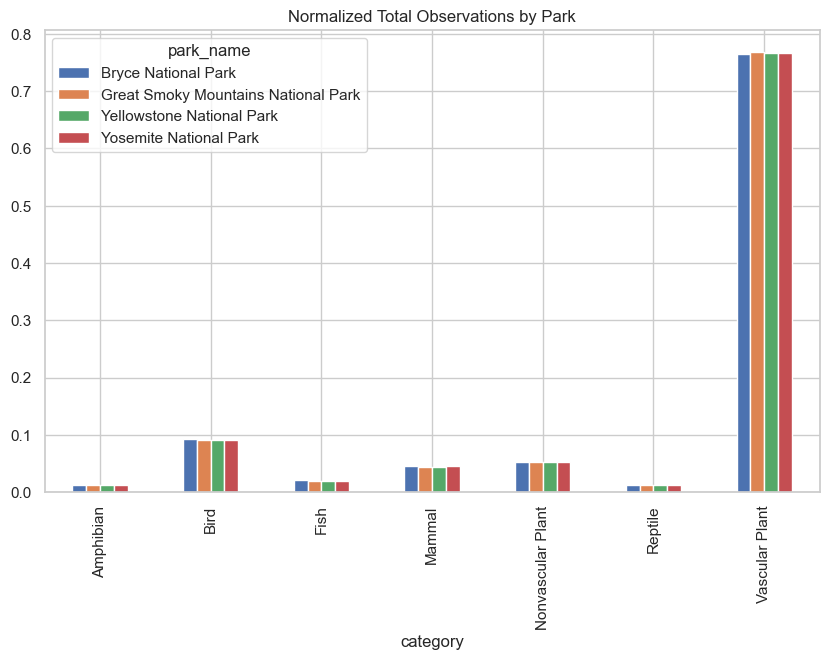


Correlations Between Parks (Normalized Endangered Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.997899,0.999459,0.998950
Great Smoky Mountains National Park,0.997899,1.000000,0.998425,0.999363
Yellowstone National Park,0.999459,0.998425,1.000000,0.999663
Yosemite National Park,0.998950,0.999363,0.999663,1.000000


In [26]:
# Normalize observations within each park
agg_df['normalized_total'] = agg_df['total_observations'] / agg_df.groupby('park_name')['total_observations'].transform('sum')
agg_df['normalized_endangered'] = agg_df['endangered_observations'] / agg_df.groupby('park_name')['endangered_observations'].transform('sum')

# Pivot normalized data for correlation analysis
normalized_total_pivot = agg_df.pivot(index='category', columns='park_name', values='normalized_total')
normalized_endangered_pivot = agg_df.pivot(index='category', columns='park_name', values='normalized_endangered')

# Check correlations between parks for normalized total observations
total_correlations = normalized_total_pivot.corr()
print("Correlations Between Parks (Normalized Total Observations):")
display(total_correlations)

normalized_total_pivot.plot(kind='bar', figsize=(10, 6), title='Normalized Total Observations by Park')
plt.show()

# Check correlations between parks for normalized endangered observations
endangered_correlations = normalized_endangered_pivot.corr()
print("\nCorrelations Between Parks (Normalized Endangered Observations):")
display(endangered_correlations)

### Observations

* Perfect correlation between parks, in the combined dataset!
* But what can explain this? We did not find such a correlation in the datasets before combining them.
* Let's do several more checks.

### Compare Raw Data Across Parks

In the combined dataset without normalization

In [25]:
raw_pivot = agg_df.pivot(index='category', columns='park_name', values='total_observations')
print("Raw Observations by Park:")
# print(raw_pivot)
display(raw_pivot)
# Check correlations between parks for normalized total observations
raw_correlations = raw_pivot.corr()
print("Correlations Between Parks (Not Normalized Total Observations):")
display(raw_correlations)


Raw Observations by Park:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
category,,,,
Amphibian,7542,5876,19937,11713
Bird,58590,42869,144300,86612
Fish,12823,9482,31459,19137
Mammal,28830,21056,70701,42533
Nonvascular Plant,32992,24857,83021,49783
Reptile,8141,5841,20061,11779
Vascular Plant,484373,364882,1218162,727895


Correlations Between Parks (Not Normalized Total Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.999993,0.999996,0.999997
Great Smoky Mountains National Park,0.999993,1.000000,0.999999,0.999999
Yellowstone National Park,0.999996,0.999999,1.000000,1.000000
Yosemite National Park,0.999997,0.999999,1.000000,1.000000


### Observations

* Still perfect correlation between parks.  
So the normalization didn't cause the correlation.